Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [165]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [167]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [170]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("dataset/Train")
data_dir_test = pathlib.Path('dataset/Test')

In [172]:
    image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
    print(image_count_train)
    image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
    print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [176]:
batch_size = 32
img_height = 180
img_width = 180
num_classes =9

Use 80% of the images for training, and 20% for validation.

In [179]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height, img_height),  # Resize images to a consistent size 
    batch_size=batch_size,         # Number of images per batch
    label_mode='int'      
)

Found 2239 files belonging to 9 classes.


In [181]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height, img_height),  # Resize images to a consistent size 
    batch_size=batch_size,         # Number of images per batch
    label_mode='int'      
)

Found 118 files belonging to 9 classes.


In [183]:
# Split the dataset into (x_train, y_train), (x_test, y_test)
x_train, y_train = zip(*[(images.numpy(), labels.numpy()) for images, labels in train_ds])
x_train = tf.concat(x_train, axis=0)
y_train = tf.concat(y_train, axis=0)

x_test, y_test = zip(*[(images.numpy(), labels.numpy()) for images, labels in test_ds])
x_test = tf.concat(x_test, axis=0)
y_test = tf.concat(y_test, axis=0)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (2239, 180, 180, 3)
y_train shape: (2239,)
x_test shape: (118, 180, 180, 3)
y_test shape: (118,)


In [184]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [185]:
# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [187]:
# Convert class vectors to binary class matrices.
#y_train = tf.keras.utils.to_categorical(y_train, num_classes)
#y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [188]:
# Function to plot sample images
def plot_sample_images(images, labels, class_names, num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

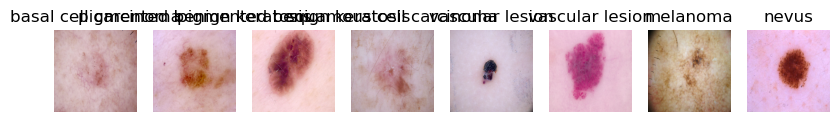

In [189]:
plot_sample_images(x_train, y_train , class_names,num_images=8)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [198]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [201]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')  # Output layer for 9 classes
])

C:\Users\razneesh\anaconda24\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [204]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [206]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [208]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 400ms/step - accuracy: 0.1824 - loss: 53.7261 - val_accuracy: 0.2288 - val_loss: 2.2489
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 431ms/step - accuracy: 0.3082 - loss: 1.9714 - val_accuracy: 0.1780 - val_loss: 2.2005
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 33s 471ms/step - accuracy: 0.2646 - loss: 2.0067 - val_accuracy: 0.2203 - val_loss: 3.0946
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 38s 545ms/step - accuracy: 0.2913 - loss: 2.0534 - val_accuracy: 0.2034 - val_loss: 2.6409
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 37s 533ms/step - accuracy: 0.3439 - loss: 1.8451 - val_accuracy: 0.2119 - val_loss: 2.6372
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 37s 531ms/step - accuracy: 0.3292 - loss: 1.8123 - val_accuracy: 0.1356 - val_loss: 2.2721
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 37s 523ms/step - accuracy: 0.2176 - loss: 2.0406 - val_accuracy: 0.1525 - val_loss: 2.3127
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 36s 512ms/step - accuracy: 0.2302 - loss: 1.9875 - val_acc

### Visualizing training results

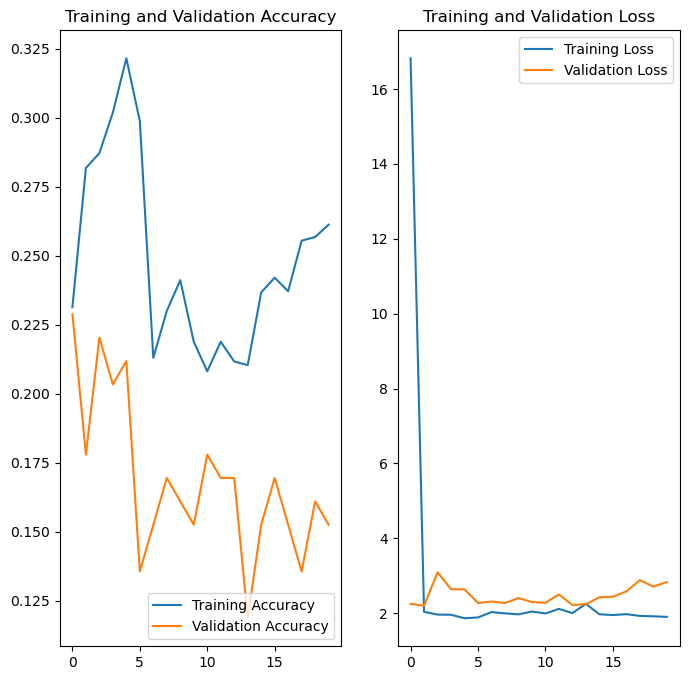

In [211]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Observation 
 #### It is a clear case of underfitting 

In [ ]:
#let augmentation and check

In [248]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen_aug = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [250]:
train_aug_ds = train_datagen_aug.flow_from_directory(
    data_dir_train,
    target_size=(img_height, img_height),  # Resize images to a consistent size 
    batch_size=batch_size,         # Number of images per batch
    class_mode='categorical'
)

Found 2239 images belonging to 9 classes.


In [252]:
test_aug_ds = train_datagen_aug.flow_from_directory(
    data_dir_test,
    target_size=(img_height, img_height),  # Resize images to a consistent size 
    batch_size=batch_size,         # Number of images per batch
    class_mode='categorical'
)

Found 118 images belonging to 9 classes.


In [254]:
# Get a batch of images and labels from the generator
images, labels = next(train_aug_ds)

# Print the shape of the batch of images and labels
print("Batch of images shape:", images.shape)
print("Batch of labels shape:", labels.shape)


Batch of images shape: (32, 180, 180, 3)
Batch of labels shape: (32, 9)


In [256]:
# Get a batch of images and labels from the generator
images, labels = next(test_aug_ds)

# Print the shape of the batch of images and labels
print("Batch of images shape:", images.shape)
print("Batch of labels shape:", labels.shape)

Batch of images shape: (32, 180, 180, 3)
Batch of labels shape: (32, 9)


In [244]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [258]:
# Train again with augmented data
history_aug = model.fit(
    train_aug_ds,
    validation_data=test_aug_ds,
    epochs=20
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.3212 - loss: 1.8289 - val_accuracy: 0.2627 - val_loss: 2.3296
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.4180 - loss: 1.6378 - val_accuracy: 0.2966 - val_loss: 2.1922
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.4442 - loss: 1.5794 - val_accuracy: 0.2966 - val_loss: 2.1749
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.4466 - loss: 1.5385 - val_accuracy: 0.3220 - val_loss: 2.6407
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.4484 - loss: 1.5716 - val_accuracy: 0.3136 - val_loss: 2.1825
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.4872 - loss: 1.4775 - val_accuracy: 0.2797 - val_loss: 2.1632
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.4931 - loss: 1.4238 - val_accuracy: 0.3051 - val_loss: 2.1346
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5200 - loss: 1.4227 - val_accuracy: 0.3475 - val_loss:

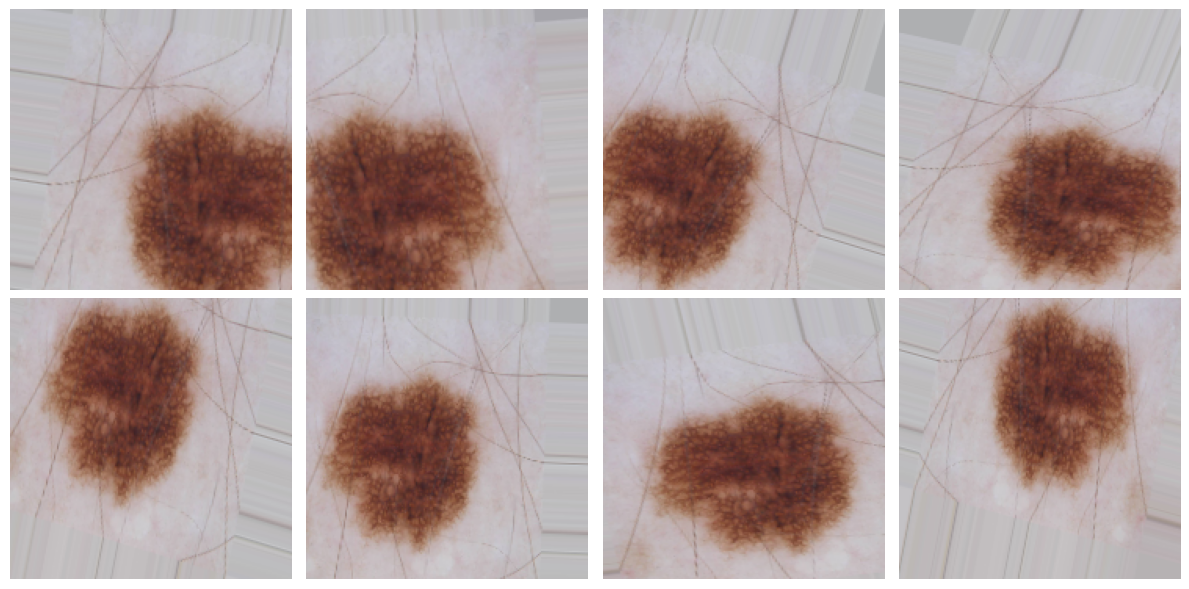

In [262]:
# Visualize how your augmentation strategy works for one instance of the training image.

from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load a sample image from the training directory
sample_image_path = f"{data_dir_train}/nevus/ISIC_0000019.jpg"  
sample_image = load_img(sample_image_path, target_size=(img_height, img_height))  # Resize to input size
sample_image_array = img_to_array(sample_image)  # Convert to numpy array
sample_image_array = np.expand_dims(sample_image_array, axis=0)  # Add batch dimension

# Use your augmentation strategy to generate augmented images
augmented_images = train_datagen_aug.flow(sample_image_array, batch_size=1)

# Visualize the augmented images
plt.figure(figsize=(12, 6))
for i in range(8):  # Show 8 augmented versions
    augmented_image = next(augmented_images)[0]  # Get the augmented image from the batch
    augmented_image = np.clip(augmented_image * 255, 0, 255).astype('uint8')  # Convert back to range [0, 255]
    plt.subplot(2, 4, i + 1)
    plt.imshow(augmented_image)
    plt.axis('off')

plt.tight_layout()
plt.show()


#### Class Distribution 



In [267]:
from collections import Counter

# Counting instances in each class
class_counts = Counter(train_aug_ds.classes)
print("Class Distribution:", class_counts)

# Least and most dominant classes
least_common = min(class_counts, key=class_counts.get)
most_common = max(class_counts, key=class_counts.get)

print(f"Least common class: {least_common} with {class_counts[least_common]} samples")
print(f"Most common class: {most_common} with {class_counts[most_common]} samples")

Class Distribution: Counter({5: 462, 3: 438, 1: 376, 4: 357, 7: 181, 8: 139, 0: 114, 2: 95, 6: 77})
Least common class: 6 with 77 samples
Most common class: 5 with 462 samples


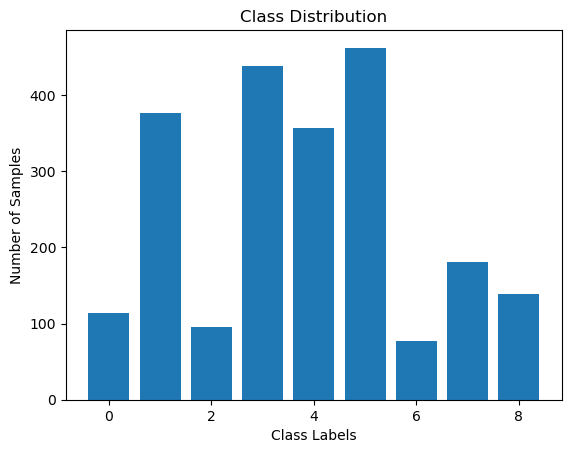

In [269]:
# Example class distribution
class_counts = {5: 462, 3: 438, 1: 376, 4: 357, 7: 181, 8: 139, 0: 114, 2: 95, 6: 77}

# Plot
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()


### Handling Class imbalance

In [285]:
import Augmentor
from Augmentor import Pipeline

# Create augmented images for underrepresented classes
output_dir = "Balancedata"
pipeline = Pipeline(source_directory=data_dir_train, output_directory=output_dir)

pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
pipeline.zoom_random(probability=0.5, percentage_area=0.8)
pipeline.flip_left_right(probability=0.5)

pipeline.sample(1000)  # Generate additional samples

Initialised with 2239 image(s) found.
Output directory set to dataset\Train\Balancedata.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2613CBE29D0>: 100%|█| 1000/1000 [00:28<00:00, 34.89 Sampl


### Training the model

In [289]:
balanced_train_datagen = ImageDataGenerator(rescale=1.0/255)
balance_data_dir = "dataset\Train\Balancedata"
balanced_train_data = balanced_train_datagen.flow_from_directory(
    balance_data_dir,
    target_size=(img_height, img_height),  # Resize images to a consistent size 
    batch_size=batch_size,         # Number of images per batch
    class_mode='categorical'
)


Found 1000 images belonging to 9 classes.


In [294]:
# Train again
history_balanced = model.fit(
    balanced_train_data,
    validation_data=test_aug_ds,
    epochs=20
)


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7211 - loss: 0.6849 - val_accuracy: 0.3390 - val_loss: 3.1728
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 885ms/step - accuracy: 0.7916 - loss: 0.6365 - val_accuracy: 0.2712 - val_loss: 3.6752
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 869ms/step - accuracy: 0.7532 - loss: 0.6217 - val_accuracy: 0.3305 - val_loss: 3.4293
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 873ms/step - accuracy: 0.7947 - loss: 0.5885 - val_accuracy: 0.2966 - val_loss: 3.4740
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 869ms/step - accuracy: 0.7826 - loss: 0.6118 - val_accuracy: 0.3644 - val_loss: 3.3213
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 870ms/step - accuracy: 0.7835 - loss: 0.5946 - val_accuracy: 0.3051 - val_loss: 4.8246
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 869ms/step - accuracy: 0.8216 - loss: 0.5052 - val_accuracy: 0.3220 - val_loss: 4.4933
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 868ms/step - accuracy: 0.8126 - loss: 0.5756 - val_accurac

### Visualizing the results

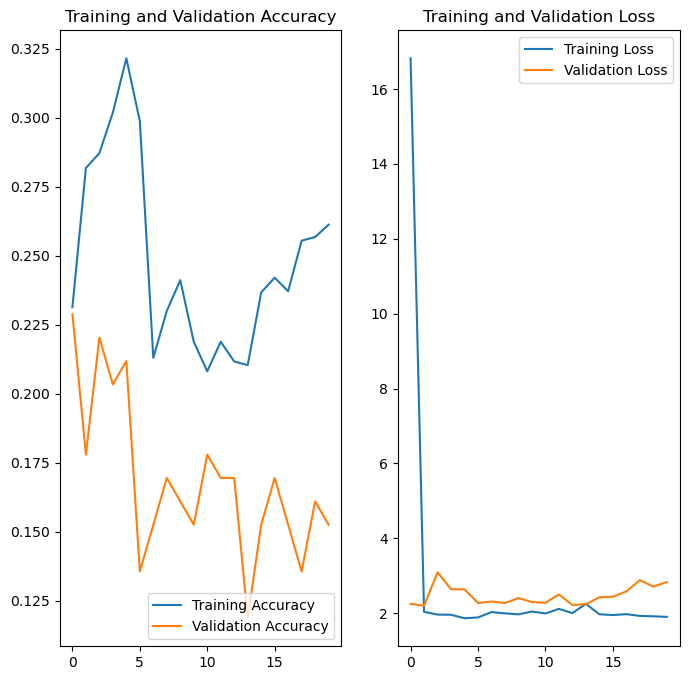

In [297]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The model has overfit to the training data. Validation performance is not improving because the model cannot generalize well to unseen data. Applying L2 regularization, Dropout layer can help improve model generalization.

#### Create a training dataset

In [323]:
# Training and validation datasets
train_datagen = ImageDataGenerator(rescale=1.0/255)
train_data = train_datagen.flow_from_directory(
    balance_data_dir,
    target_size=(img_height, img_height),  # Resize images to a consistent size 
    batch_size=batch_size,         # Number of images per batch
    class_mode='categorical'
)

Found 1000 images belonging to 9 classes.


#### Create a validation dataset

In [326]:
#test_datagen = ImageDataGenerator(rescale=1.0/255)
#test_data = test_datagen.flow_from_directory(
#    data_dir_test,
#    target_size=(img_height, img_height),  # Resize images to a consistent size 
#    batch_size=batch_size,         # Number of images per batch
#    class_mode='categorical'
#)

In [328]:
test_data = train_datagen_aug.flow_from_directory(
    data_dir_test,
    target_size=(img_height, img_height),  # Resize images to a consistent size 
    batch_size=batch_size,         # Number of images per batch
    class_mode='categorical'
)

Found 118 images belonging to 9 classes.


#### Create your model (make sure to include normalization)

In [370]:
# Build the CNN model
from tensorflow.keras.layers import  BatchNormalization
from tensorflow.keras.regularizers import l2
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    #BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    #BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    #BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
   # BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    #BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(9, activation='softmax')  # Output layer for 9 classes
])

In [372]:
# summary of the model
print(model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 41, 41, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 872,713 (3.33 MB)

 Trainable params: 872,713 (3.33 MB)

 Non-trainable params: 0 (0.00 B)

None


#### Compile your model (Choose optimizer and loss function appropriately)

In [375]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Train your model

In [378]:
epochs = 10
history_balanced = model.fit(
    train_data,
    validation_data=test_data,
    epochs=epochs
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 749ms/step - accuracy: 0.2029 - loss: 7.8334 - val_accuracy: 0.1356 - val_loss: 4.5502
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 861ms/step - accuracy: 0.1981 - loss: 3.8670 - val_accuracy: 0.1356 - val_loss: 2.9352
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 855ms/step - accuracy: 0.1963 - loss: 2.6516 - val_accuracy: 0.1186 - val_loss: 2.4891
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 877ms/step - accuracy: 0.2408 - loss: 2.2623 - val_accuracy: 0.1864 - val_loss: 2.2983
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 865ms/step - accuracy: 0.3031 - loss: 2.0027 - val_accuracy: 0.2542 - val_loss: 2.1637
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 873ms/step - accuracy: 0.3299 - loss: 1.8876 - val_accuracy: 0.2288 - val_loss: 2.1489
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 854ms/step - accuracy: 0.2984 - loss: 1.8357 - val_accuracy: 0.1949 - val_loss: 2.1308
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 853ms/step - accuracy: 0.3893 - loss: 1.7517 - val_accu

#### **Todo:**  Visualize the model results

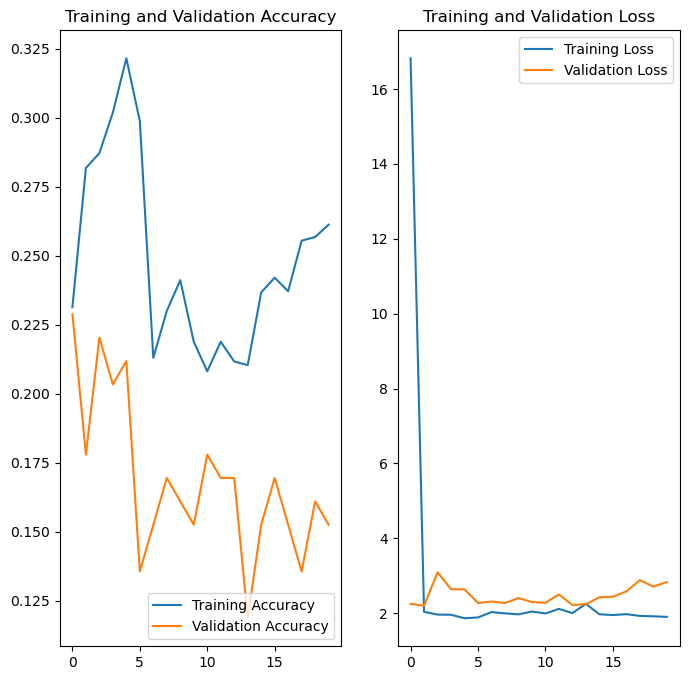

In [368]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

